# A Global Study of Critcal Care Laboratory Values Reference Range

selected lab tests:Max. sodium, max. creatinine, max. lactate, min. hemoglobin

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
from scipy.stats import gaussian_kde
from scipy import integrate
from sklearn.neighbors import KernelDensity
from scipy.stats import entropy
import scipy.stats
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 1 Data extraction

Data from adult were extracted with customized postgreSQL query scripts. Here we just load extracted data in CSV format.

P.S. In plagh database, we define age >= 18 as adult, Chinese standard

In [2]:
data_mimic = pd.read_csv('../datasets/processed data/MIMIC-data.csv')
data_aumc = pd.read_csv('../datasets/processed data/AUMC-data.csv')
data_eicu = pd.read_csv('../datasets/processed data/eCRD-data.csv')
data_plagh = pd.read_csv('../datasets/processed data/PLAGH-data.csv')
data_HJ23 = pd.read_csv('../datasets/processed data/HJ23-data.csv')

## 1.1 Normal range definition

Interested laboratory tests' normal range and definition is defined as below:

In [3]:
lab_ranges = {'ALBUMIN':[3.5, 5.5], 
              'BICARBONATE': [22,32],
              'CALCIUM': [8.4,10.3],
              'CREATININE': [0.4,1.1],
              'GLUCOSE':[70.0, 100.0],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'MAGNESIUM': [1.6,2.6],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145],
              'IONIZEDCALCIUM': [1.1, 1.35],
              'WBC': [3.5, 10.5]
             }



lab_units = {
        'ALBUMIN': 'g/dL', 
        'BICARBONATE': 'mEq/L',
        'CALCIUM': 'mg/dL',
        'CREATININE': 'mEq/L',
        'GLUCOSE': 'mg/dL',
        'HEMOGLOBIN': 'g/dL',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'SODIUM':'mmol/L',
        'IONIZEDCALCIUM': 'mmol/L',
        'WBC': '10^3/uL'
       }

In [4]:
database_all=[data_mimic,data_eicu,data_plagh,data_aumc,data_HJ23]

# 2 fuction define

In [5]:
def get_OVL(dist1, dist2):
#     """
#         except for 'sodium_max' 
#         use [0,inf] to calculate the overlap
#     """
    func = lambda x: min(dist1.pdf(x), dist2.pdf(x))
    return integrate.quad(func, 0, np.inf)

In [6]:
def get_OVL_sodium(dist1, dist2):
#     """
#         'sodium_max' ranges about 120-160
#         use [0,inf] will cause integrate.quad() return 0
#     """
    func = lambda x: min(dist1.pdf(x), dist2.pdf(x))
    return integrate.quad(func, 100, 180)

In [7]:
def cohen_d(x, y):
    """
    Return SMD between two distributions
    """
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(
        ((nx - 1) * np.std(x, ddof=1)**2 +
         (ny - 1) * np.std(y, ddof=1)**2) / dof)

In [8]:
#return a normal distribution with 'val1' and 'val2'quantile(2.5% and 95%)
def ResumeNorm(val1, val2):
    norm_dist = scipy.stats.norm
    norm_val1 = norm_dist.ppf(0.025)
    norm_val2 = norm_dist.ppf(0.975)
    a = (val1 - val2) / (norm_val1 - norm_val2)
    b = val1 - a * norm_val1
    return scipy.stats.norm(b, a)

# 3 Comparation between databases

In [9]:
#selected lab tests
lab_names=['sodium_max','creatinine_max','lactate_max','hemoglobin_min','bicarbonate_min']

## 3.1 Compare all the ICU patients

sodium_max
37106 128745 59320 19789 4714
creatinine_max
37057 128778 59011 19496 4656
lactate_max
15937 52395 15 11114 3902
hemoglobin_min
36733 128136 58250 19715 4658
bicarbonate_min
36856 121307 1162 18995 4363


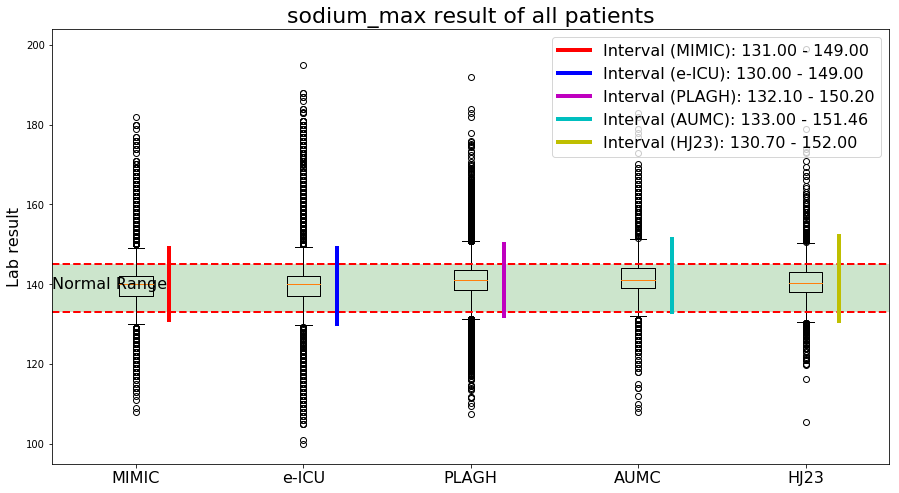

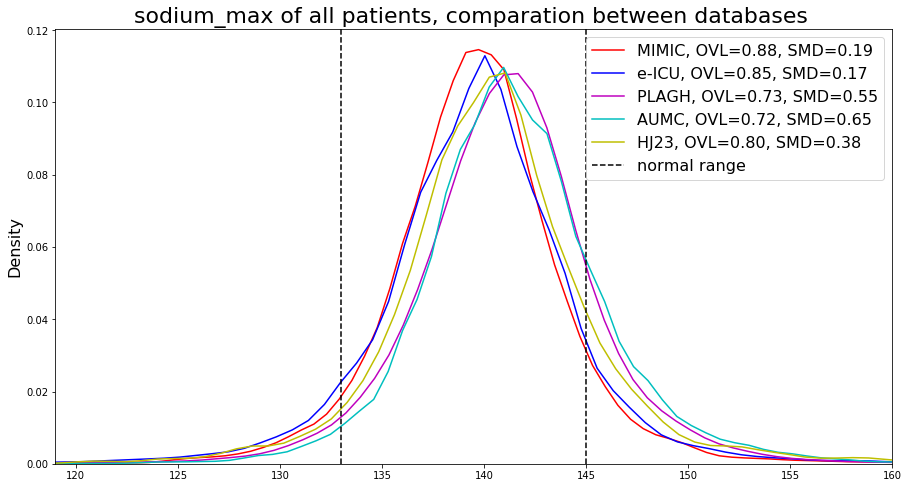

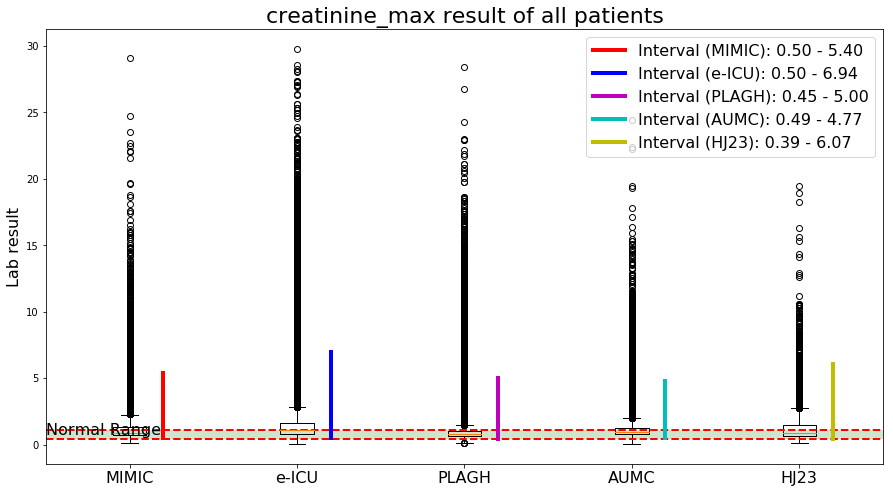

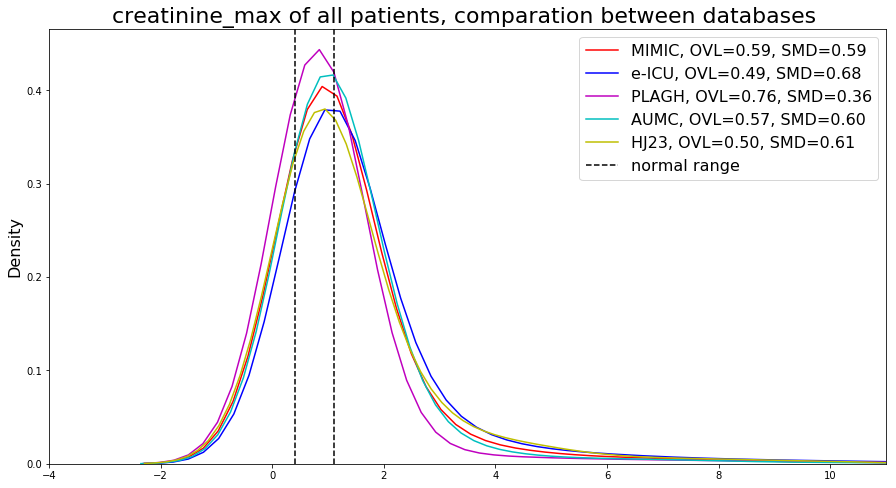

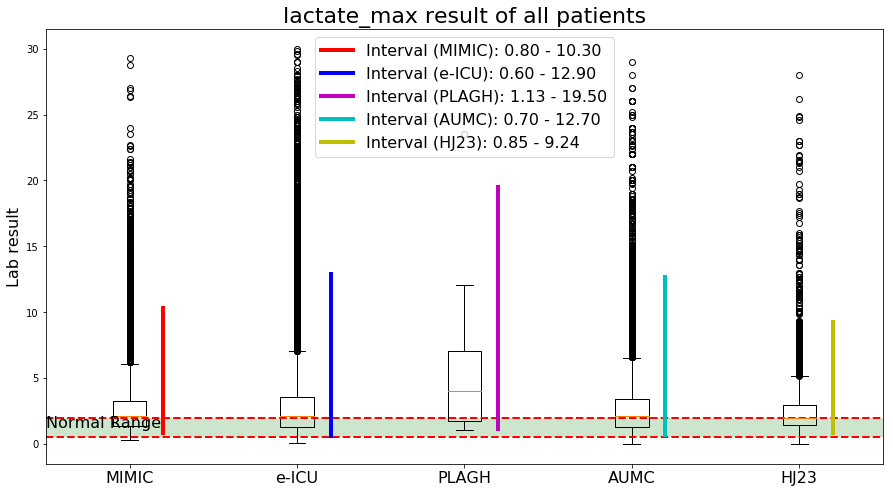

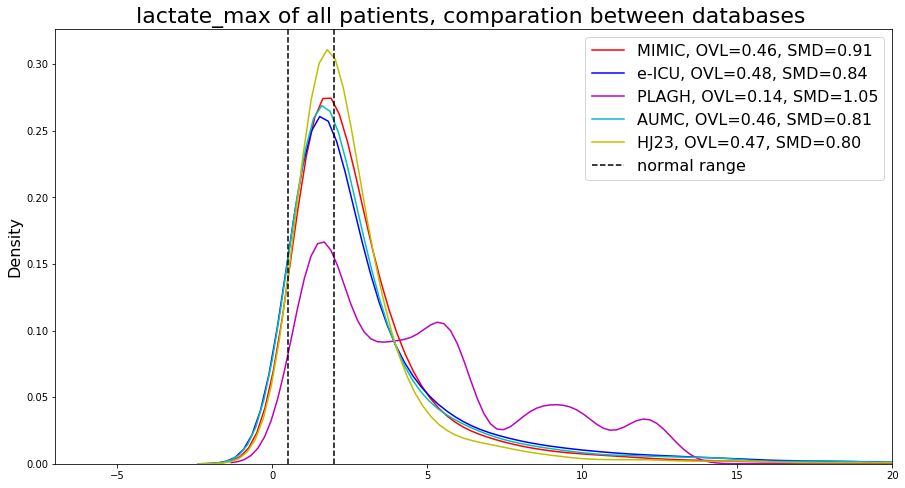

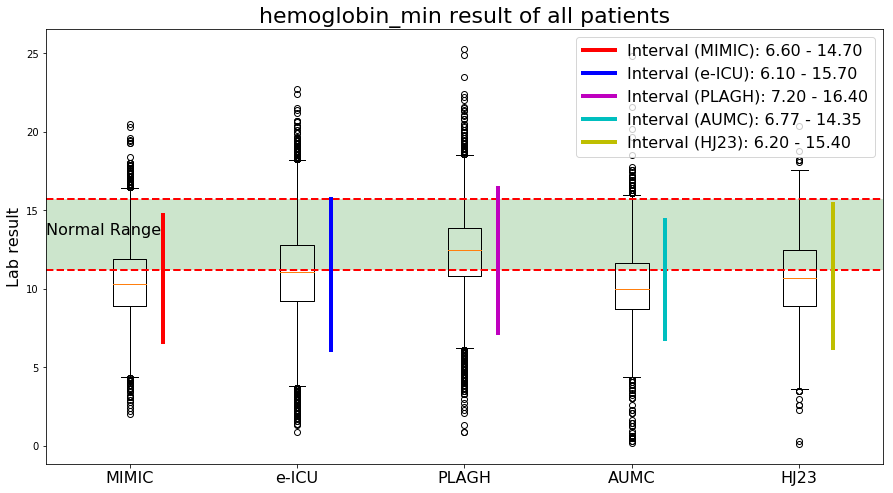

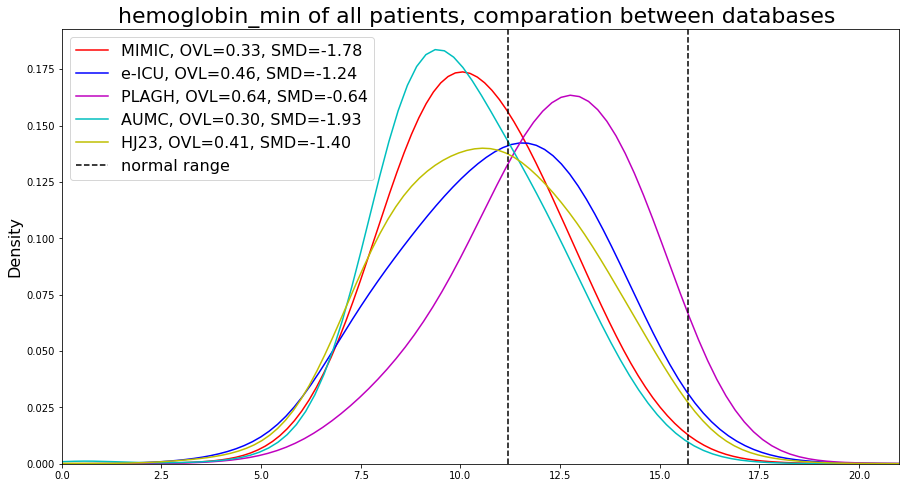

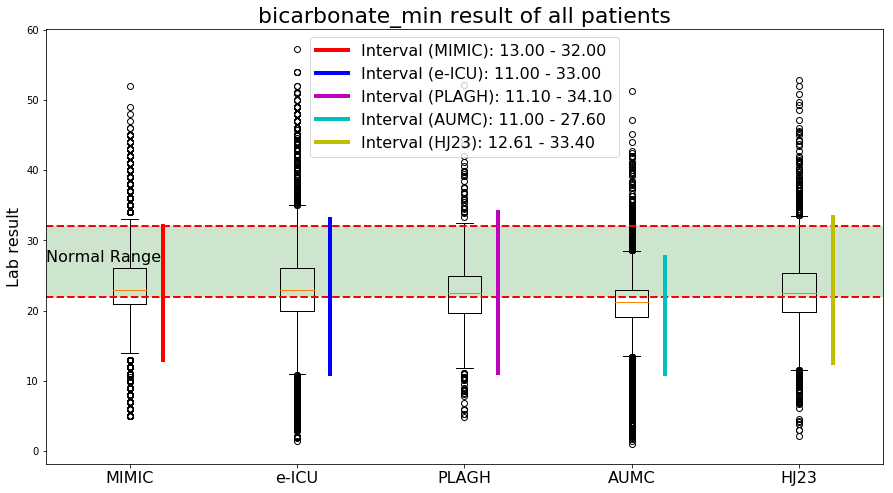

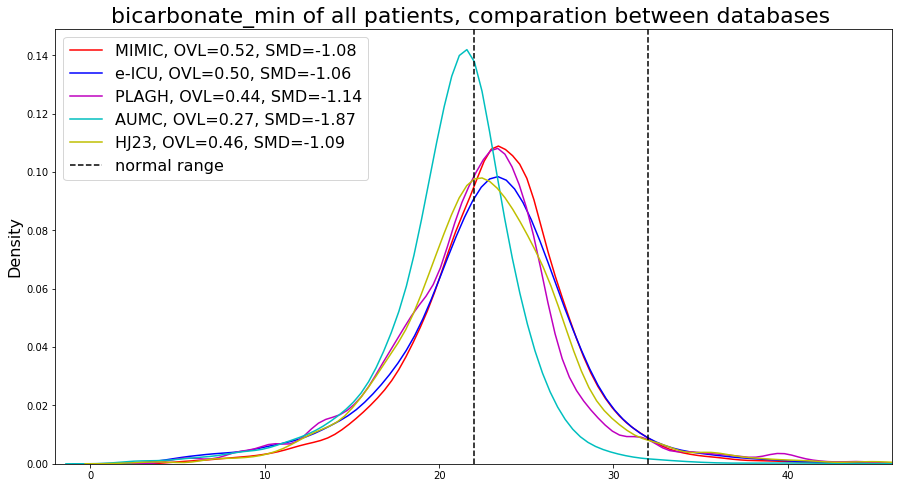

In [10]:
for item in lab_names:
    if item not in data_plagh.columns.values:
        data_plagh[item]=np.nan
    
    range_name=item.split('_')[0].upper()
     # count patients
    n_mimic = data_mimic[item].dropna().count()
    n_eicu = data_eicu[item].dropna().count()
    n_plagh = data_plagh[item].dropna().count()
    n_aumc=data_aumc[item].dropna().count()
    n_HJ23=data_HJ23[item].dropna().count()
    print(item)
    print(n_mimic,n_eicu,n_plagh,n_aumc,n_HJ23)
    
    ## Null hypothesis: are the mean of patient distribution same as normal value distribution? 
    # Sample normal range distribution first
    range_dist = ResumeNorm(lab_ranges[range_name][0], lab_ranges[range_name][1])
    norm_sample_mimic = range_dist.rvs(size=n_mimic, random_state=0)
    norm_sample_eicu = range_dist.rvs(size=n_eicu, random_state=0)
    norm_sample_plagh = range_dist.rvs(size=n_plagh, random_state=0)
    norm_sample_aumc = range_dist.rvs(size=n_aumc, random_state=0)
    norm_sample_HJ23 = range_dist.rvs(size=n_HJ23, random_state=0)
    
    #two list to store 2.5% & 97.5%
    a1=[]
    a2=[]

    # add 95% percentail 
    a1.append( data_mimic[item].quantile(0.025))
    a2.append( data_mimic[item].quantile(0.975))
    a1.append( data_eicu[item].quantile(0.025))
    a2.append( data_eicu[item].quantile(0.975))
    a1.append( data_plagh[item].quantile(0.025))
    a2.append( data_plagh[item].quantile(0.975))
    a1.append(data_aumc[item].quantile(0.025))
    a2.append( data_aumc[item].quantile(0.975))
    a1.append(data_HJ23[item].quantile(0.025))
    a2.append( data_HJ23[item].quantile(0.975))
    
    #boxplot
    fig, ax = plt.subplots(figsize=(15,8))
    #plot the boxes
    plt.boxplot([data_mimic[item].dropna(),
                 data_eicu[item].dropna(), 
                 data_plagh[item].dropna(),
                 data_aumc[item].dropna(),
                 data_HJ23[item].dropna()],widths=0.2)
    plt.xticks([1,2,3,4,5],['MIMIC','e-ICU','PLAGH','AUMC','HJ23'], fontsize=16)

    
    
    #plot the normal range of each labtest
    plt.plot([0.5,5.5],[lab_ranges[range_name][0], lab_ranges[range_name][0]],'r--',linewidth=2)
    plt.plot([0.5,5.5],[lab_ranges[range_name][1], lab_ranges[range_name][1]],'r--',linewidth=2)
    plt.fill_between([0.5,5.5],[lab_ranges[range_name][0]], [lab_ranges[range_name][1]],facecolor='green',alpha=0.2)
    plt.text(0.5,(lab_ranges[range_name][0]+lab_ranges[range_name][1])/2,'Normal Range',fontsize=16)

    #plot the 95% interval of each labtest of each database
    plt.plot([1.2,1.2],[a1[0],a2[0]],'r-',linewidth=4,label='Interval (MIMIC): {} - {}'.format(format(a1[0], '.2f'), format(a2[0], '.2f')))
    plt.plot([2.2,2.2],[a1[1],a2[1]],'b-',linewidth=4,label='Interval (e-ICU): {} - {}'.format(format(a1[1], '.2f'), format(a2[1], '.2f')))
    plt.plot([3.2,3.2],[a1[2],a2[2]],'m-',linewidth=4,label='Interval (PLAGH): {} - {}'.format(format(a1[2], '.2f'), format(a2[2], '.2f')))
    plt.plot([4.2,4.2],[a1[3],a2[3]],'c-',linewidth=4,label='Interval (AUMC): {} - {}'.format(format(a1[3], '.2f'), format(a2[3], '.2f')))
    plt.plot([5.2,5.2],[a1[4],a2[4]],'y-',linewidth=4,label='Interval (HJ23): {} - {}'.format(format(a1[4], '.2f'), format(a2[4], '.2f')))

    #plt.xlabel(item, fontsize=16)
    plt.xlim([0.5,5.5])
    #plt.ylim([np.nanmin(a1),np.nanmax(a2)])
    plt.ylabel('Lab result', fontsize=16)
    plt.title('{} result of all patients'.format(item), fontsize=22)
    plt.legend(fontsize=16)
    
    
    # SMD
    smd_mimic = '%.2f'%cohen_d(data_mimic[item].dropna(), norm_sample_mimic)
    smd_eicu = '%.2f'%cohen_d(data_eicu[item].dropna(), norm_sample_eicu)
    smd_aumc = '%.2f'%cohen_d(data_aumc[item].dropna(), norm_sample_aumc)
    smd_HJ23 = '%.2f'%cohen_d(data_HJ23[item].dropna(), norm_sample_HJ23)

    # Test case on pandas kde: gaussian kde 
    data_kde_mimic = gaussian_kde(data_mimic[item].dropna())
    data_kde_eicu = gaussian_kde(data_eicu[item].dropna())
    data_kde_aumc = gaussian_kde(data_aumc[item].dropna())
    data_kde_HJ23 = gaussian_kde(data_HJ23[item].dropna())

    #OVL
    ovl_mimic =  '%.2f'%max(get_OVL(data_kde_mimic, range_dist))
    ovl_eicu = '%.2f'%max(get_OVL(data_kde_eicu, range_dist))
    ovl_aumc = '%.2f'%max(get_OVL(data_kde_aumc, range_dist))
    ovl_HJ23 = '%.2f'%max(get_OVL(data_kde_HJ23, range_dist))

    #calculate for PLAGH, some missing labtest
    if len(data_plagh[item].dropna()) != 0:
        data_kde_plagh = gaussian_kde(data_plagh[item].dropna())
        ovl_plagh = '%.2f'%max(get_OVL(data_kde_plagh, range_dist))
        smd_plagh = '%.2f'%cohen_d(data_plagh[item].dropna(), norm_sample_plagh)
    else:
        smd_plagh = np.nan
        ovl_plagh = np.nan
    
    #sodium_max
    if item == 'sodium_max':
        ovl_mimic =  '%.2f'%max(get_OVL_sodium(data_kde_mimic, range_dist))
        ovl_eicu = '%.2f'%max(get_OVL_sodium(data_kde_eicu, range_dist))
        ovl_aumc = '%.2f'%max(get_OVL_sodium(data_kde_aumc, range_dist))
        ovl_HJ23 = '%.2f'%max(get_OVL_sodium(data_kde_HJ23, range_dist))
        ovl_plagh = '%.2f'%max(get_OVL_sodium(data_kde_plagh, range_dist))


    fig, ax = plt.subplots(figsize=(15,8))
    plot_range = [min(a1[1], lab_ranges[range_name][0]), max(a2[1], lab_ranges[range_name][1])]
    diff = plot_range[1] - plot_range[0]


    sns.kdeplot(data_mimic[item].dropna(),color='r',bw=0.8,
                label='MIMIC, OVL={}, SMD={}'.format(ovl_mimic,smd_mimic ))
    sns.kdeplot(data_eicu[item].dropna(),color='b',bw=0.8,
                label='e-ICU, OVL={}, SMD={}'.format(ovl_eicu,smd_eicu))
    sns.kdeplot(data_plagh[item].dropna(),color='m',bw=0.8,
                label='PLAGH, OVL={}, SMD={}'.format(ovl_plagh,smd_plagh))
    sns.kdeplot(data_aumc[item].dropna(),color='c',bw=0.8,
                label='AUMC, OVL={}, SMD={}'.format(ovl_aumc,smd_aumc))
    sns.kdeplot(data_HJ23[item].dropna(),color='y',bw=0.8,
                label='HJ23, OVL={}, SMD={}'.format(ovl_HJ23,smd_HJ23))


    plt.axvline(lab_ranges[range_name][0],color='k',linestyle='--', label='normal range')
    plt.axvline(lab_ranges[range_name][1],color='k',linestyle='--')


    plt.title('{} of all patients, comparation between databases '.format(item), fontsize=22)
    #plt.xlabel(l + ' ' + u, fontsize=16)
    plt.ylabel("Density", fontsize=16)
    plt.legend(fontsize=16)
    plt.xlim(round(plot_range[0] - 0.6 * diff), round(plot_range[1] + 0.6 * diff))

## 3.2 expired patients

sodium_max
2742 7398 3381 1897 703
creatinine_max
2714 7376 3383 1843 689
lactate_max
1960 5189 3 1754 618
hemoglobin_min
2704 7355 3266 1889 694
bicarbonate_min
2713 6977 220 1888 643


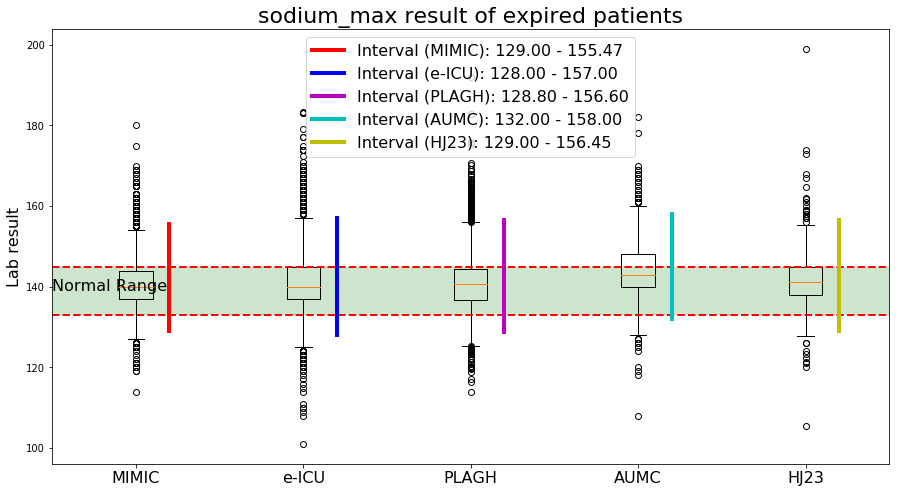

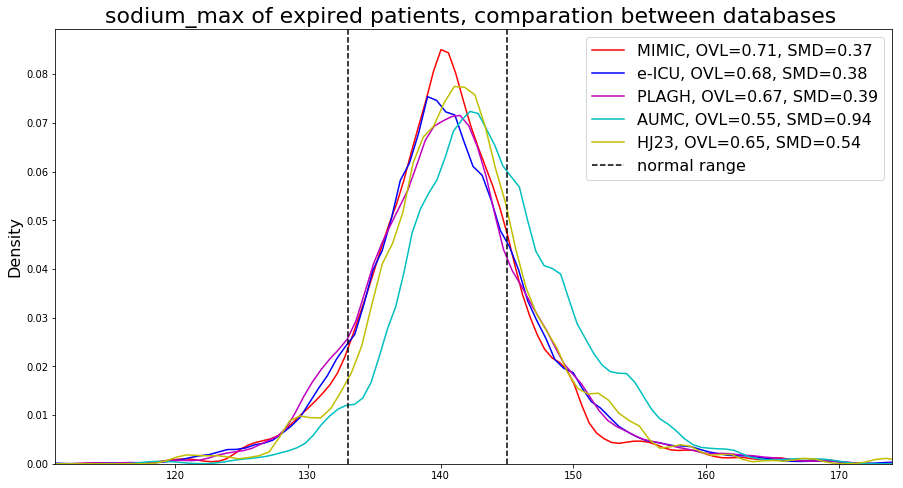

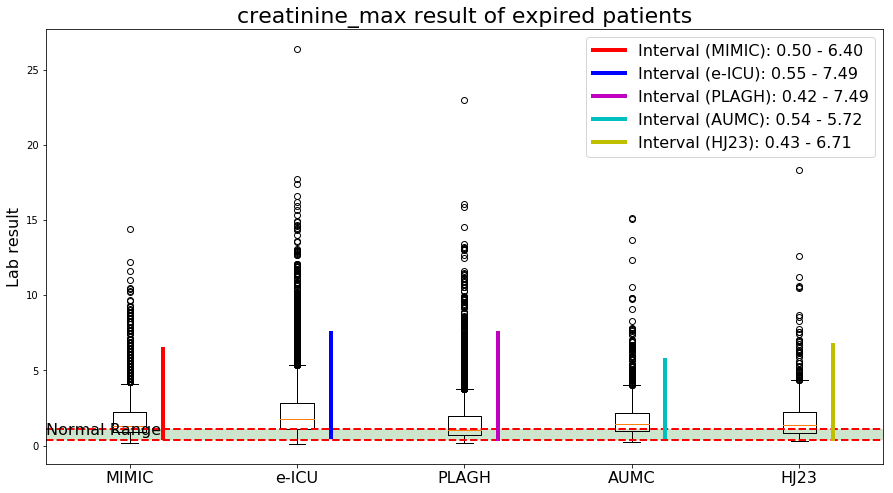

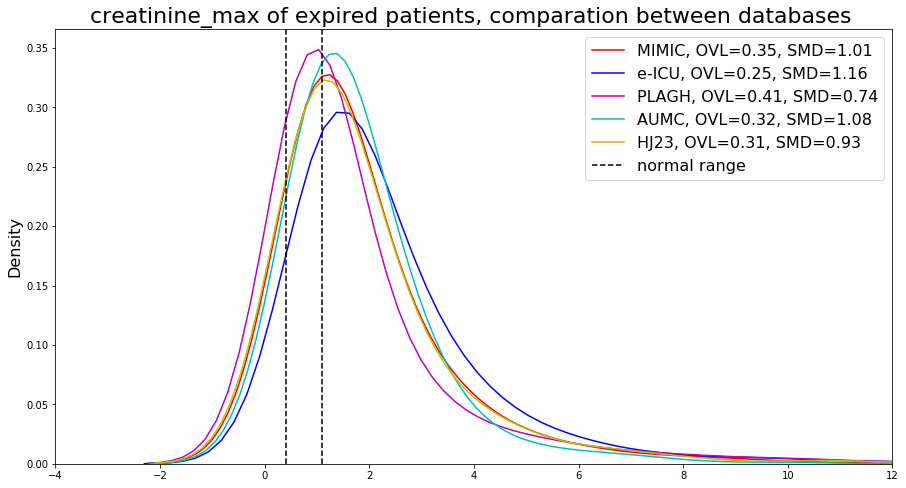

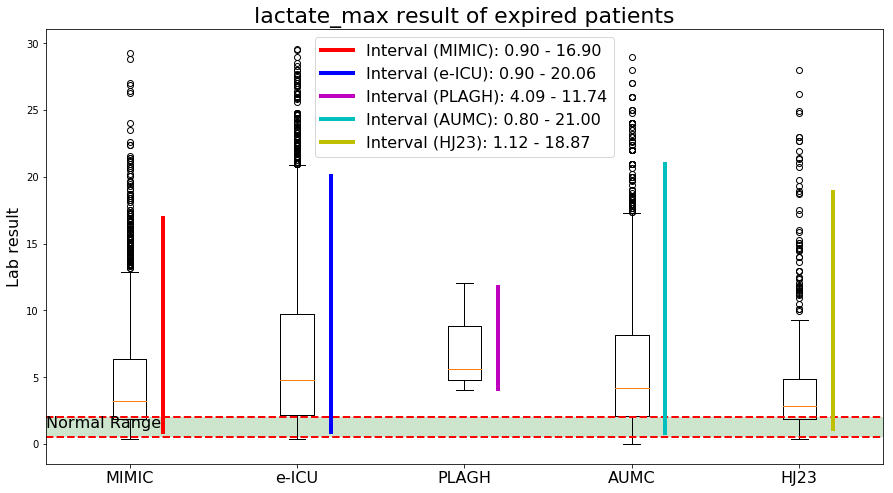

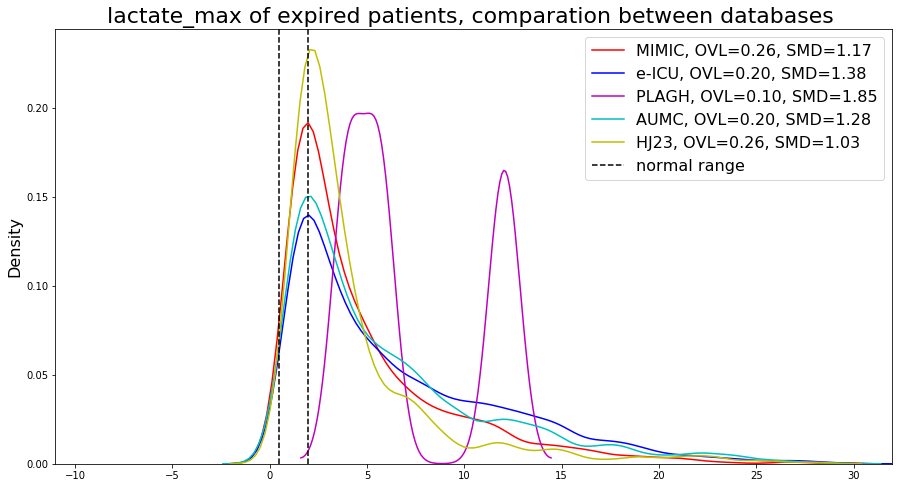

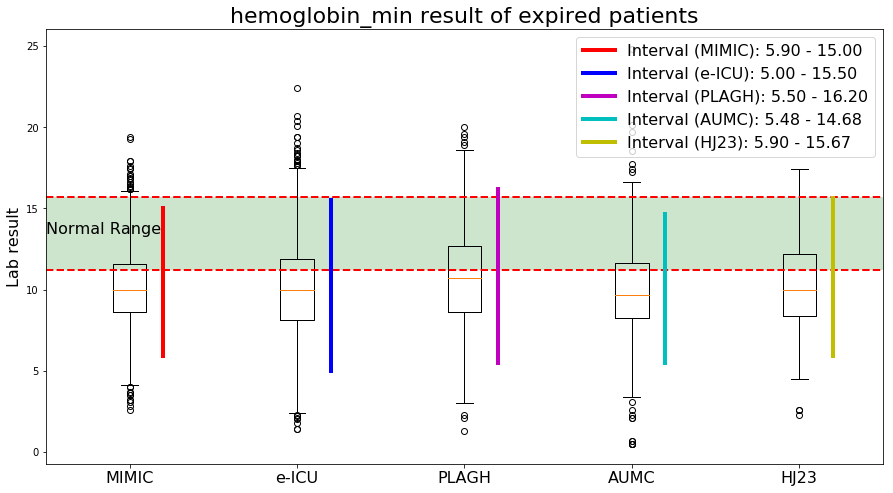

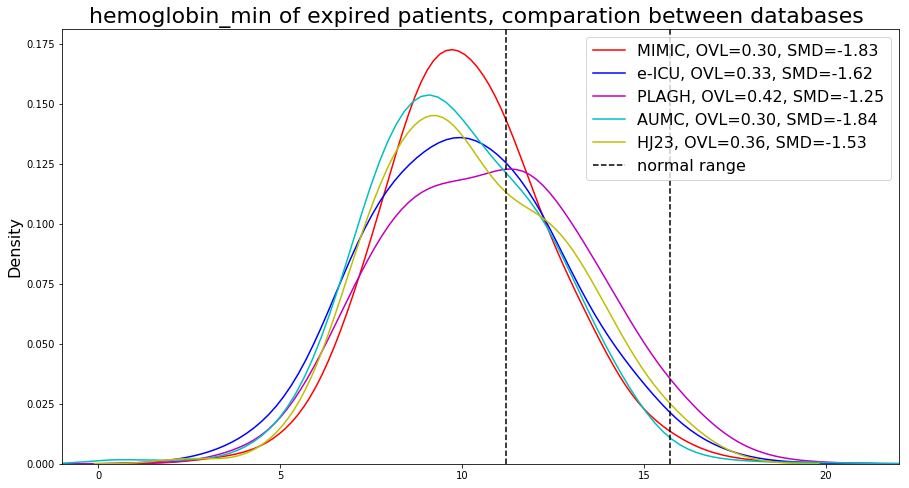

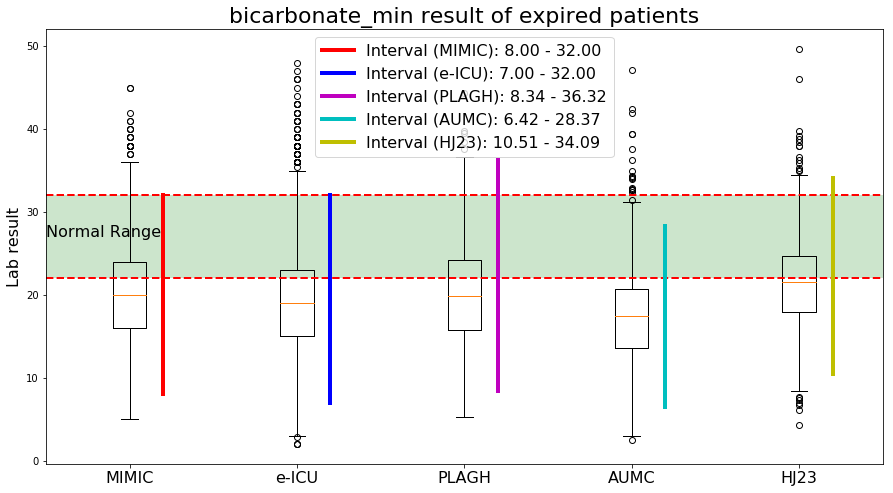

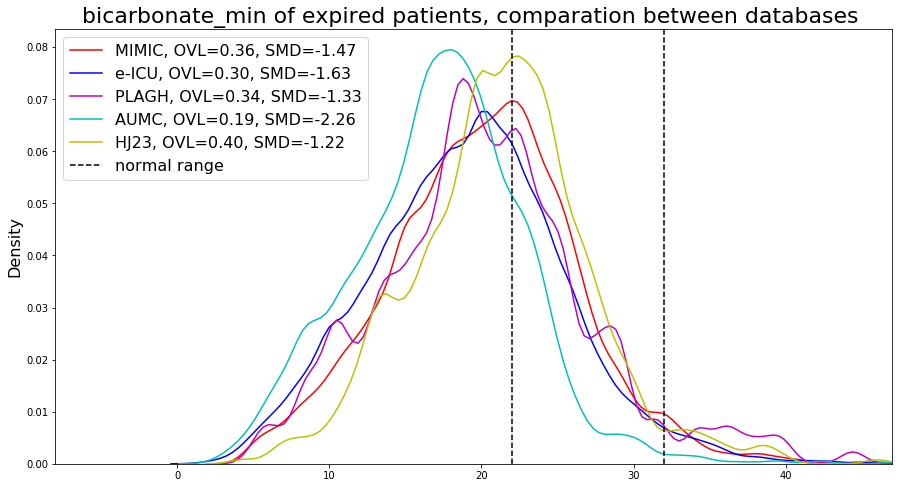

In [11]:
for item in lab_names:
    if item not in data_plagh.columns.values:
        data_plagh[item]=np.nan
    
    range_name=item.split('_')[0].upper()
    
    expire_mimic=data_mimic.loc[data_mimic['icu_expire_flag']==1,:]
    expire_eicu=data_eicu.loc[data_eicu['icu_expire_flag']==1,:]
    expire_plagh=data_plagh.loc[data_plagh['icu_expire_flag']==1,:]
    expire_aumc=data_aumc.loc[data_aumc['icu_expire_flag']==1,:]
    expire_HJ23=data_HJ23.loc[data_HJ23['icu_expire_flag']==1,:]
    
    
     # count patients
    n_mimic = expire_mimic[item].dropna().count()
    n_eicu = expire_eicu[item].dropna().count()
    n_plagh = expire_plagh[item].dropna().count()
    n_aumc=expire_aumc[item].dropna().count()
    n_HJ23=expire_HJ23[item].dropna().count()
    print(item)
    print(n_mimic,n_eicu,n_plagh,n_aumc,n_HJ23)
    
    ## Null hypothesis: are the mean of patient distribution same as normal value distribution? 
    # Sample normal range distribution first
    range_dist = ResumeNorm(lab_ranges[range_name][0], lab_ranges[range_name][1])
    norm_sample_mimic = range_dist.rvs(size=n_mimic, random_state=0)
    norm_sample_eicu = range_dist.rvs(size=n_eicu, random_state=0)
    norm_sample_plagh = range_dist.rvs(size=n_plagh, random_state=0)
    norm_sample_aumc = range_dist.rvs(size=n_aumc, random_state=0)
    norm_sample_HJ23 = range_dist.rvs(size=n_HJ23, random_state=0)
    
    #two list to store 2.5% & 97.5%
    a1=[]
    a2=[]

    # add 95% percentail 
    a1.append( expire_mimic[item].quantile(0.025))
    a2.append( expire_mimic[item].quantile(0.975))
    a1.append( expire_eicu[item].quantile(0.025))
    a2.append( expire_eicu[item].quantile(0.975))
    a1.append( expire_plagh[item].quantile(0.025))
    a2.append( expire_plagh[item].quantile(0.975))
    a1.append( expire_aumc[item].quantile(0.025))
    a2.append( expire_aumc[item].quantile(0.975))
    a1.append( expire_HJ23[item].quantile(0.025))
    a2.append( expire_HJ23[item].quantile(0.975))
    
    #boxplot
    fig, ax = plt.subplots(figsize=(15,8))
    #plot the boxes
    plt.boxplot([expire_mimic[item].dropna(),
                 expire_eicu[item].dropna(), 
                 expire_plagh[item].dropna(),
                 expire_aumc[item].dropna(),
                 expire_HJ23[item].dropna()],widths=0.2)
    plt.xticks([1,2,3,4,5],['MIMIC','e-ICU','PLAGH','AUMC','HJ23'], fontsize=16)

    
    
    #plot the normal range of each labtest
    plt.plot([0.5,5.5],[lab_ranges[range_name][0], lab_ranges[range_name][0]],'r--',linewidth=2)
    plt.plot([0.5,5.5],[lab_ranges[range_name][1], lab_ranges[range_name][1]],'r--',linewidth=2)
    plt.fill_between([0.5,5.5],[lab_ranges[range_name][0]], [lab_ranges[range_name][1]],facecolor='green',alpha=0.2)
    plt.text(0.5,(lab_ranges[range_name][0]+lab_ranges[range_name][1])/2,'Normal Range',fontsize=16)

    #plot the 95% interval of each labtest of each database
    plt.plot([1.2,1.2],[a1[0],a2[0]],'r-',linewidth=4,label='Interval (MIMIC): {} - {}'.format(format(a1[0], '.2f'), format(a2[0], '.2f')))
    plt.plot([2.2,2.2],[a1[1],a2[1]],'b-',linewidth=4,label='Interval (e-ICU): {} - {}'.format(format(a1[1], '.2f'), format(a2[1], '.2f')))
    plt.plot([3.2,3.2],[a1[2],a2[2]],'m-',linewidth=4,label='Interval (PLAGH): {} - {}'.format(format(a1[2], '.2f'), format(a2[2], '.2f')))
    plt.plot([4.2,4.2],[a1[3],a2[3]],'c-',linewidth=4,label='Interval (AUMC): {} - {}'.format(format(a1[3], '.2f'), format(a2[3], '.2f')))
    plt.plot([5.2,5.2],[a1[4],a2[4]],'y-',linewidth=4,label='Interval (HJ23): {} - {}'.format(format(a1[4], '.2f'), format(a2[4], '.2f')))

    #plt.xlabel(item, fontsize=16)
    plt.xlim([0.5,5.5])
    #plt.ylim([np.nanmin(a1),np.nanmax(a2)])
    plt.ylabel('Lab result', fontsize=16)
    plt.title('{} result of expired patients'.format(item), fontsize=22)
    plt.legend(fontsize=16)
    
    
    # SMD
    smd_mimic = '%.2f'%cohen_d(expire_mimic[item].dropna(), norm_sample_mimic)
    smd_eicu = '%.2f'%cohen_d(expire_eicu[item].dropna(), norm_sample_eicu)
    smd_aumc = '%.2f'%cohen_d(expire_aumc[item].dropna(), norm_sample_aumc)
    smd_HJ23 = '%.2f'%cohen_d(expire_HJ23[item].dropna(), norm_sample_HJ23)

    # Test case on pandas kde: gaussian kde 
    data_kde_mimic = gaussian_kde(expire_mimic[item].dropna())
    data_kde_eicu = gaussian_kde(expire_eicu[item].dropna())
    data_kde_aumc = gaussian_kde(expire_aumc[item].dropna())
    data_kde_HJ23 = gaussian_kde(expire_HJ23[item].dropna())

    #OVL
    ovl_mimic =  '%.2f'%max(get_OVL(data_kde_mimic, range_dist))
    ovl_eicu = '%.2f'%max(get_OVL(data_kde_eicu, range_dist))
    ovl_aumc = '%.2f'%max(get_OVL(data_kde_aumc, range_dist))
    ovl_HJ23 = '%.2f'%max(get_OVL(data_kde_HJ23, range_dist))

    #calculate for PLAGH, some missing labtest
    if len(data_plagh[item].dropna()) != 0:
        data_kde_plagh = gaussian_kde(expire_plagh[item].dropna())
        ovl_plagh = '%.2f'%max(get_OVL(data_kde_plagh, range_dist))
        smd_plagh = '%.2f'%cohen_d(expire_plagh[item].dropna(), norm_sample_plagh)
    else:
        smd_plagh = np.nan
        ovl_plagh = np.nan


    #sodium_max
    if item == 'sodium_max':
        ovl_mimic =  '%.2f'%max(get_OVL_sodium(data_kde_mimic, range_dist))
        ovl_eicu = '%.2f'%max(get_OVL_sodium(data_kde_eicu, range_dist))
        ovl_aumc = '%.2f'%max(get_OVL_sodium(data_kde_aumc, range_dist))
        ovl_HJ23 = '%.2f'%max(get_OVL_sodium(data_kde_HJ23, range_dist))
        ovl_plagh = '%.2f'%max(get_OVL_sodium(data_kde_plagh, range_dist))

    fig, ax = plt.subplots(figsize=(15,8))
    plot_range = [min(a1[1], lab_ranges[range_name][0]), max(a2[1], lab_ranges[range_name][1])]
    diff = plot_range[1] - plot_range[0]


    sns.kdeplot(expire_mimic[item].dropna(),color='r',bw=0.8,
                label='MIMIC, OVL={}, SMD={}'.format(ovl_mimic,smd_mimic ))
    sns.kdeplot(expire_eicu[item].dropna(),color='b',bw=0.8,
                label='e-ICU, OVL={}, SMD={}'.format(ovl_eicu,smd_eicu))
    sns.kdeplot(expire_plagh[item].dropna(),color='m',bw=0.8,
                label='PLAGH, OVL={}, SMD={}'.format(ovl_plagh,smd_plagh))
    sns.kdeplot(expire_aumc[item].dropna(),color='c',bw=0.8,
                label='AUMC, OVL={}, SMD={}'.format(ovl_aumc,smd_aumc))
    sns.kdeplot(expire_HJ23[item].dropna(),color='y',bw=0.8,
                label='HJ23, OVL={}, SMD={}'.format(ovl_HJ23,smd_HJ23))


    plt.axvline(lab_ranges[range_name][0],color='k',linestyle='--', label='normal range')
    plt.axvline(lab_ranges[range_name][1],color='k',linestyle='--')


    plt.title('{} of expired patients, comparation between databases '.format(item), fontsize=22)
    #plt.xlabel(l + ' ' + u, fontsize=16)
    plt.ylabel("Density", fontsize=16)
    plt.legend(fontsize=16)
    plt.xlim(round(plot_range[0] - 0.6 * diff), round(plot_range[1] + 0.6 * diff))

## 3.3 survivals

sodium_max
34364 121336 55939 17892 4011
creatinine_max
34343 121391 55628 17653 3967
lactate_max
13977 47197 12 9360 3284
hemoglobin_min
34029 120770 54984 17826 3964
bicarbonate_min
34143 114319 942 17107 3720


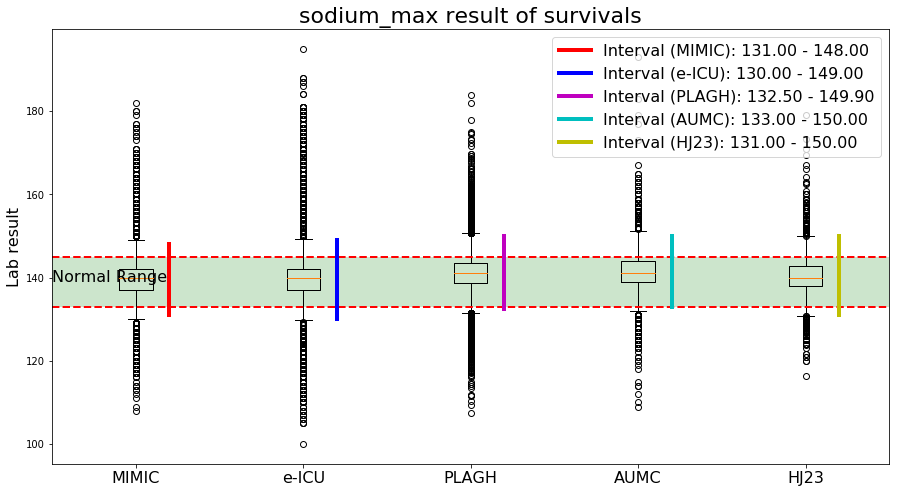

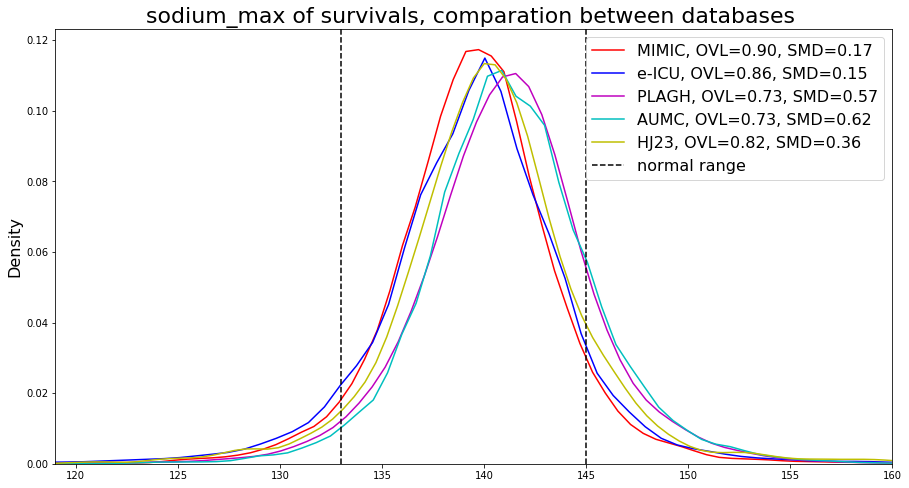

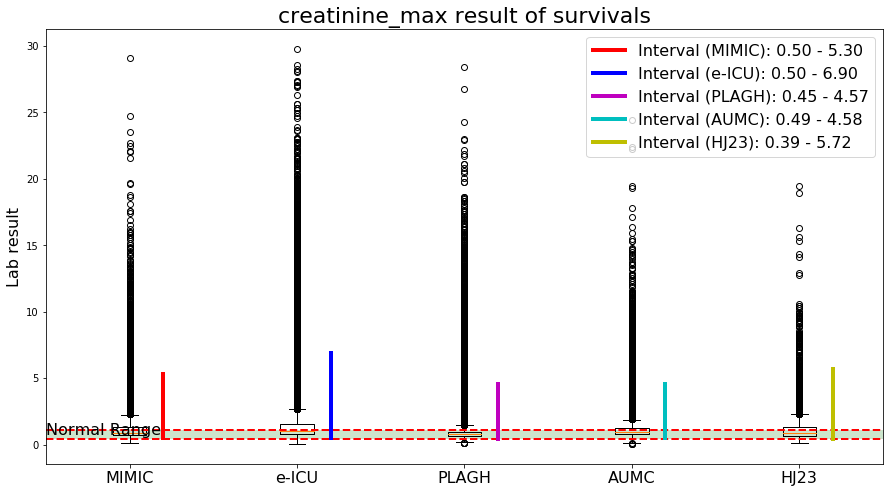

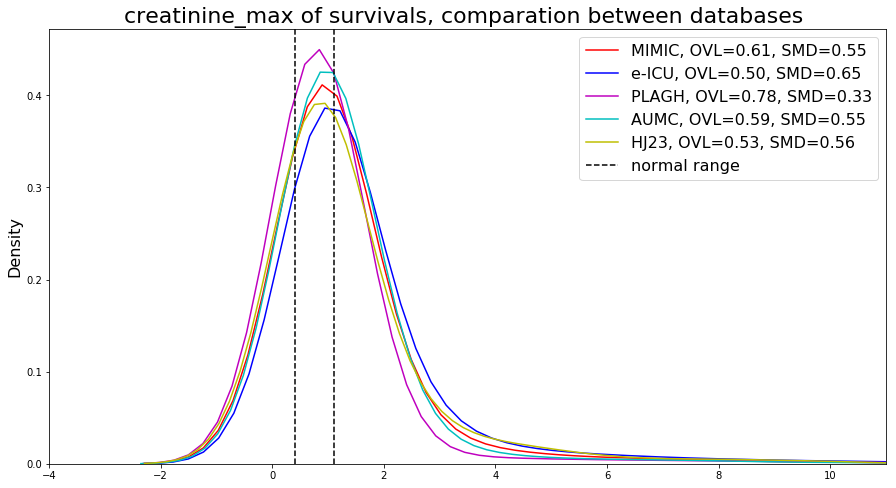

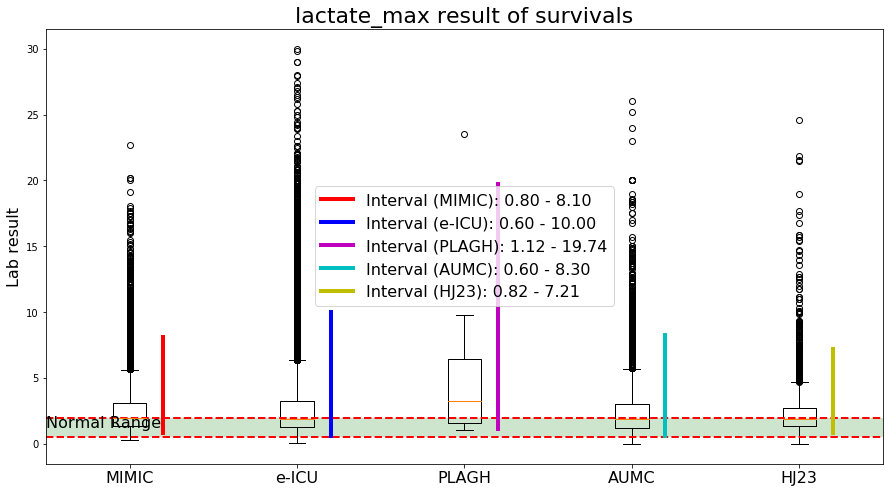

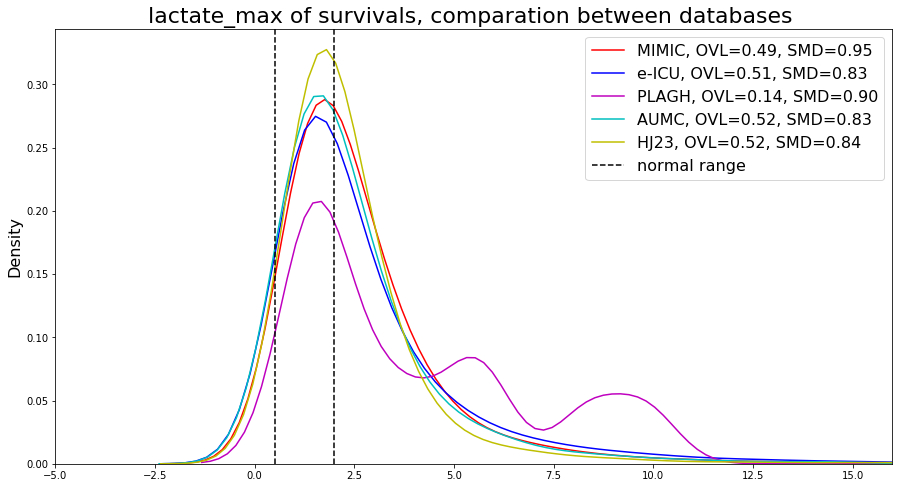

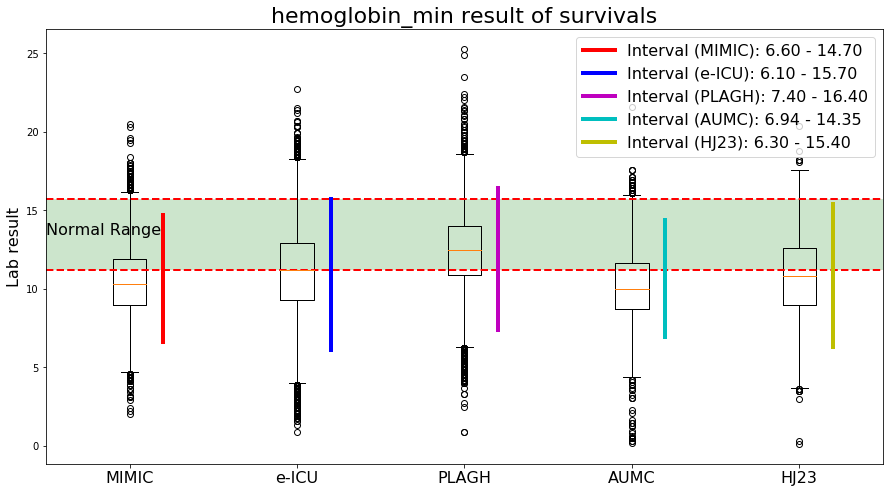

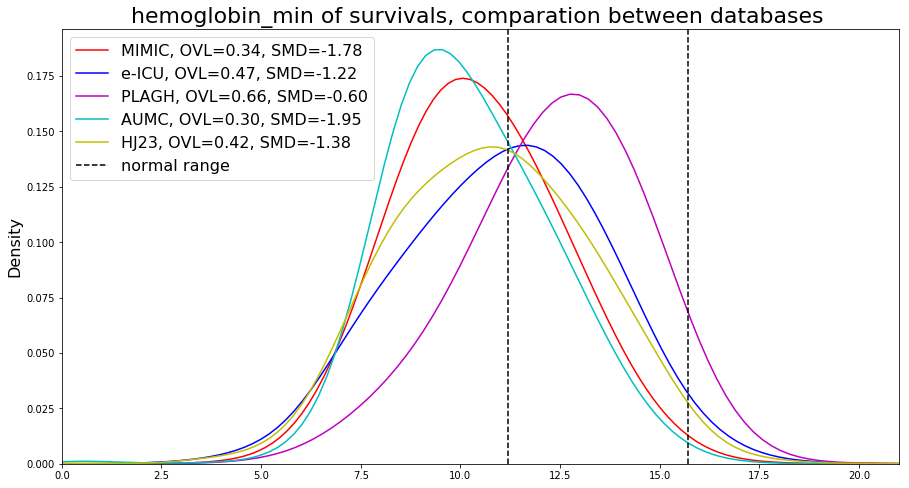

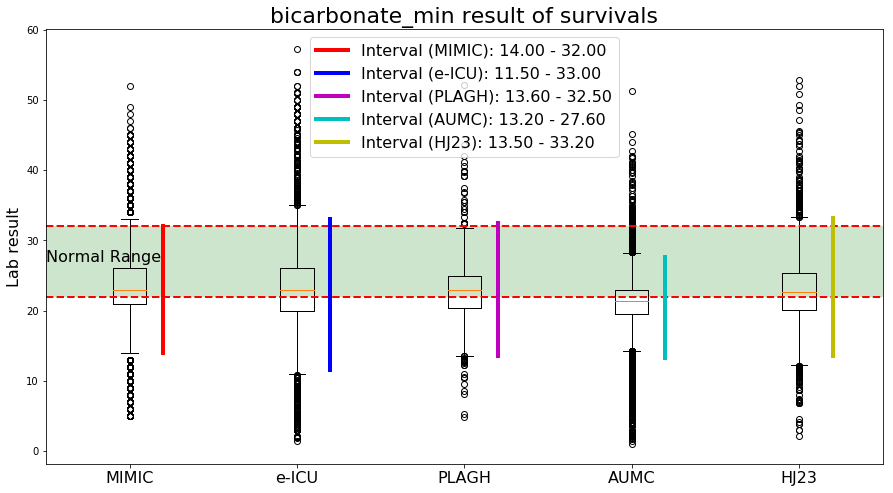

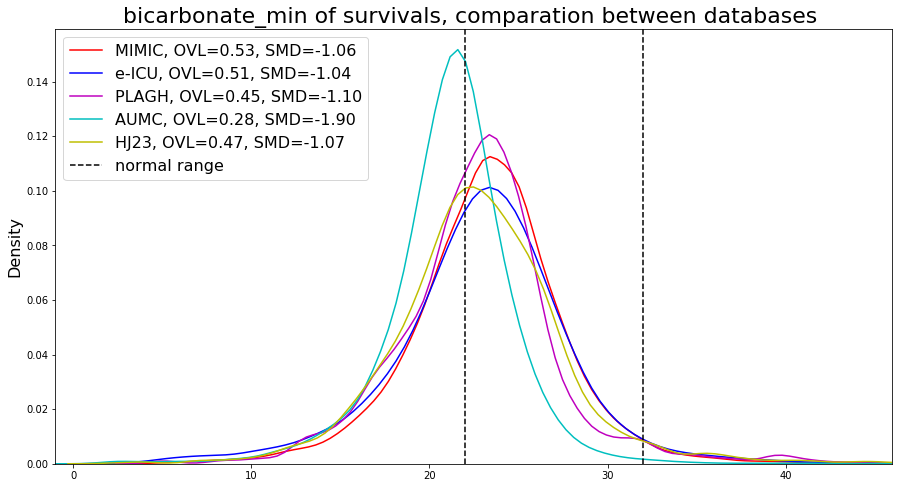

In [12]:
for item in lab_names:
    if item not in data_plagh.columns.values:
        data_plagh[item]=np.nan
    
    range_name=item.split('_')[0].upper()
    
    sur_mimic=data_mimic.loc[data_mimic['icu_expire_flag']==0,:]
    sur_eicu=data_eicu.loc[data_eicu['icu_expire_flag']==0,:]
    sur_plagh=data_plagh.loc[data_plagh['icu_expire_flag']==0,:]
    sur_aumc=data_aumc.loc[data_aumc['icu_expire_flag']==0,:]
    sur_HJ23=data_HJ23.loc[data_HJ23['icu_expire_flag']==0,:]
    
    
     # count patients
    n_mimic = sur_mimic[item].dropna().count()
    n_eicu = sur_eicu[item].dropna().count()
    n_plagh = sur_plagh[item].dropna().count()
    n_aumc=sur_aumc[item].dropna().count()
    n_HJ23=sur_HJ23[item].dropna().count()
    print(item)
    print(n_mimic,n_eicu,n_plagh,n_aumc,n_HJ23)
    
    ## Null hypothesis: are the mean of patient distribution same as normal value distribution? 
    # Sample normal range distribution first
    range_dist = ResumeNorm(lab_ranges[range_name][0], lab_ranges[range_name][1])
    norm_sample_mimic = range_dist.rvs(size=n_mimic, random_state=0)
    norm_sample_eicu = range_dist.rvs(size=n_eicu, random_state=0)
    norm_sample_plagh = range_dist.rvs(size=n_plagh, random_state=0)
    norm_sample_aumc = range_dist.rvs(size=n_aumc, random_state=0)
    norm_sample_HJ23 = range_dist.rvs(size=n_HJ23, random_state=0)
    
    #two list to store 2.5% & 97.5%
    a1=[]
    a2=[]

    # add 95% percentail 
    a1.append( sur_mimic[item].quantile(0.025))
    a2.append( sur_mimic[item].quantile(0.975))
    a1.append( sur_eicu[item].quantile(0.025))
    a2.append( sur_eicu[item].quantile(0.975))
    a1.append( sur_plagh[item].quantile(0.025))
    a2.append( sur_plagh[item].quantile(0.975))
    a1.append( sur_aumc[item].quantile(0.025))
    a2.append( sur_aumc[item].quantile(0.975))
    a1.append( sur_HJ23[item].quantile(0.025))
    a2.append( sur_HJ23[item].quantile(0.975))
    
    #boxplot
    fig, ax = plt.subplots(figsize=(15,8))
    #plot the boxes
    plt.boxplot([sur_mimic[item].dropna(),
                 sur_eicu[item].dropna(), 
                 sur_plagh[item].dropna(),
                 sur_aumc[item].dropna(),
                 sur_HJ23[item].dropna()],widths=0.2)
    plt.xticks([1,2,3,4,5],['MIMIC','e-ICU','PLAGH','AUMC','HJ23'], fontsize=16)

    
    
    #plot the normal range of each labtest
    plt.plot([0.5,5.5],[lab_ranges[range_name][0], lab_ranges[range_name][0]],'r--',linewidth=2)
    plt.plot([0.5,5.5],[lab_ranges[range_name][1], lab_ranges[range_name][1]],'r--',linewidth=2)
    plt.fill_between([0.5,5.5],[lab_ranges[range_name][0]], [lab_ranges[range_name][1]],facecolor='green',alpha=0.2)
    plt.text(0.5,(lab_ranges[range_name][0]+lab_ranges[range_name][1])/2,'Normal Range',fontsize=16)

    #plot the 95% interval of each labtest of each database
    plt.plot([1.2,1.2],[a1[0],a2[0]],'r-',linewidth=4,label='Interval (MIMIC): {} - {}'.format(format(a1[0], '.2f'), format(a2[0], '.2f')))
    plt.plot([2.2,2.2],[a1[1],a2[1]],'b-',linewidth=4,label='Interval (e-ICU): {} - {}'.format(format(a1[1], '.2f'), format(a2[1], '.2f')))
    plt.plot([3.2,3.2],[a1[2],a2[2]],'m-',linewidth=4,label='Interval (PLAGH): {} - {}'.format(format(a1[2], '.2f'), format(a2[2], '.2f')))
    plt.plot([4.2,4.2],[a1[3],a2[3]],'c-',linewidth=4,label='Interval (AUMC): {} - {}'.format(format(a1[3], '.2f'), format(a2[3], '.2f')))
    plt.plot([5.2,5.2],[a1[4],a2[4]],'y-',linewidth=4,label='Interval (HJ23): {} - {}'.format(format(a1[4], '.2f'), format(a2[4], '.2f')))

    #plt.xlabel(item, fontsize=16)
    plt.xlim([0.5,5.5])
    #plt.ylim([np.nanmin(a1),np.nanmax(a2)])
    plt.ylabel('Lab result', fontsize=16)
    plt.title('{} result of survivals'.format(item), fontsize=22)
    plt.legend(fontsize=16)
    
    
    # SMD
    smd_mimic = '%.2f'%cohen_d(sur_mimic[item].dropna(), norm_sample_mimic)
    smd_eicu = '%.2f'%cohen_d(sur_eicu[item].dropna(), norm_sample_eicu)
    smd_aumc = '%.2f'%cohen_d(sur_aumc[item].dropna(), norm_sample_aumc)
    smd_HJ23 = '%.2f'%cohen_d(sur_HJ23[item].dropna(), norm_sample_HJ23)

    # Test case on pandas kde: gaussian kde 
    data_kde_mimic = gaussian_kde(sur_mimic[item].dropna())
    data_kde_eicu = gaussian_kde(sur_eicu[item].dropna())
    data_kde_aumc = gaussian_kde(sur_aumc[item].dropna())
    data_kde_HJ23 = gaussian_kde(sur_HJ23[item].dropna())

    #OVL
    ovl_mimic =  '%.2f'%max(get_OVL(data_kde_mimic, range_dist))
    ovl_eicu = '%.2f'%max(get_OVL(data_kde_eicu, range_dist))
    ovl_aumc = '%.2f'%max(get_OVL(data_kde_aumc, range_dist))
    ovl_HJ23 = '%.2f'%max(get_OVL(data_kde_HJ23, range_dist))

    #calculate for PLAGH, some missing labtest
    if len(data_plagh[item].dropna()) != 0:
        data_kde_plagh = gaussian_kde(sur_plagh[item].dropna())
        ovl_plagh = '%.2f'%max(get_OVL(data_kde_plagh, range_dist))
        smd_plagh = '%.2f'%cohen_d(sur_plagh[item].dropna(), norm_sample_plagh)
    else:
        smd_plagh = np.nan
        ovl_plagh = np.nan


    #sodium_max
    if item == 'sodium_max':
        ovl_mimic =  '%.2f'%max(get_OVL_sodium(data_kde_mimic, range_dist))
        ovl_eicu = '%.2f'%max(get_OVL_sodium(data_kde_eicu, range_dist))
        ovl_aumc = '%.2f'%max(get_OVL_sodium(data_kde_aumc, range_dist))
        ovl_HJ23 = '%.2f'%max(get_OVL_sodium(data_kde_HJ23, range_dist))
        ovl_plagh = '%.2f'%max(get_OVL_sodium(data_kde_plagh, range_dist))

    fig, ax = plt.subplots(figsize=(15,8))
    plot_range = [min(a1[1], lab_ranges[range_name][0]), max(a2[1], lab_ranges[range_name][1])]
    diff = plot_range[1] - plot_range[0]


    sns.kdeplot(sur_mimic[item].dropna(),color='r',bw=0.8,
                label='MIMIC, OVL={}, SMD={}'.format(ovl_mimic,smd_mimic ))
    sns.kdeplot(sur_eicu[item].dropna(),color='b',bw=0.8,
                label='e-ICU, OVL={}, SMD={}'.format(ovl_eicu,smd_eicu))
    sns.kdeplot(sur_plagh[item].dropna(),color='m',bw=0.8,
                label='PLAGH, OVL={}, SMD={}'.format(ovl_plagh,smd_plagh))
    sns.kdeplot(sur_aumc[item].dropna(),color='c',bw=0.8,
                label='AUMC, OVL={}, SMD={}'.format(ovl_aumc,smd_aumc))
    sns.kdeplot(sur_HJ23[item].dropna(),color='y',bw=0.8,
                label='HJ23, OVL={}, SMD={}'.format(ovl_HJ23,smd_HJ23))


    plt.axvline(lab_ranges[range_name][0],color='k',linestyle='--', label='normal range')
    plt.axvline(lab_ranges[range_name][1],color='k',linestyle='--')


    plt.title('{} of survivals, comparation between databases '.format(item), fontsize=22)
    #plt.xlabel(l + ' ' + u, fontsize=16)
    plt.ylabel("Density", fontsize=16)
    plt.legend(fontsize=16)
    plt.xlim(round(plot_range[0] - 0.6 * diff), round(plot_range[1] + 0.6 * diff))